## Introduction to AWS ParallelCluster

For an overview of this workshop, please read [README.md](README.md)

This is a shortened version. Steps to prepare (before and after) for the ParallelCluster are coded in pcluster-athena.py. 

#### Before: 
- Create ssh key
- Create or use existing default VPC
- Create an S3 bucket for config, post install, sbatch, Athena++ initial condition files
- Create or use exsiting MySQL RDS database for Slurm accounting
- Update VPC security group to allow traffic to MySQL RDS
- Create a secret for RDS in AWS Secret Manager
- Upload post install script to S3
- Fill the ParallelCluster config template with values of region, VPC_ID, SUBNET_ID, KEY_NAME, POST_INSTALLSCRIPT_LOCATION and POST_INSALL_SCRIPT_ARGS 
- Upload the config file to S3

#### After
- Update VPC security group attached to the headnode to open port 8082 (SLURM REST port) to this notebook

#### Note: 
The reason to break out the process into before and after is to capture the output of the cluster creation from "pcluster create" command and display the output in the notebook.


In [3]:
# install the pcluster CLI
#!pip3 install --upgrade pip
!sudo pip3 install --upgrade aws-parallelcluster
!pcluster version

Requirement already up-to-date: aws-parallelcluster in /usr/local/lib/python3.6/site-packages (3.0.0)
You are using pip version 19.0.2, however version 21.2.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
{
  "version": "3.0.0"
}


In [4]:
import boto3
import botocore
import json
import time
import os
import sys
import base64
import docker
import pandas as pd
import importlib
import project_path # path to helper methods
from lib import workshop
from botocore.exceptions import ClientError
from IPython.display import HTML, display

#sys.path.insert(0, '.')
import pcluster_athena
importlib.reload(pcluster_athena)


# unique name of the pcluster
pcluster_name = 'myPC5c'
config_name = "config3.yaml"
REGION="us-east-1"

# default post install script include steps to compile slurm, hdf5, athena++, which could take over 25 minutes. 
# For a short workshop, we will pull compiled slurm, hdf5 and athena++ from an URL and shorten the cluster creation time to around 10 minutes. 
# default script
#post_install_script_prefix = "scripts/pcluster_post_install.sh"
# faster script
post_install_script_prefix = "scripts/pcluster_post_install_fast.sh"

# Graviton cluster - the post install script differs for the compilation of some packages.
#pcluster_name = 'myPC6g'
#config_name="config-c6g"
#post_install_script_prefix = "scripts/pcluster_post_install-6g.sh"

# create the build folder if doesn't exist already
!mkdir -p build



## Install nodejs in the current kernal

pcluster3 requires nodejs executables. We wil linstall that in the current kernal. 

SageMaker Jupyter notebook comes with multiple kernals. We use "conda_python3" in this workshop. If you need to switch to another kernal, please change the kernal in the following instructions accordingly. 

1. Open a terminal window from File/New/Ternimal - this will open a terminal with "sh" shell.
2. exetute ```bash``` command to switch to "bash" shell
3. execute ```conda activate python3```
4. execute the following commands
```

curl -o- https://raw.githubusercontent.com/nvm-sh/nvm/v0.38.0/install.sh | bash

chmod +x ~/.nvm/nvm.sh

~/.nvm/nvm.sh

bash

nvm install node

node --version
```

After you installed nodejs in the current kernel, restart the kernal by reselecting the "conda_python3" on the top right corner of the notebook. You should see the output of the version of node, such as "v16.9.1" 



In [5]:
!node --version

v16.11.0


## Load the PClusterHelper module

In [6]:
# this is used during developemnt, to reload the module after a change in the module
try:
    del sys.modules['pcluster_athena']
except:
    #ignore if the module is not loaded
    print('Module not loaded, ignore')
    
from pcluster_athena import PClusterHelper

# create the cluster - # You can rerun the rest of the notebook again with no harm. There are checks in place for existing resoources. 
pcluster_helper = PClusterHelper(pcluster_name, config_name, post_install_script_prefix)


## Create the parallel cluster
In this shortened version, we will run the cluster creation in the background, using the PClusterHelper class. 

If you are using the default post install script, the process will take up to 30 minutes. The two steps that take longer than the rest are the creation of a MySQL RDS instance, and the installation of Slurm, Athena++, HDF5 libs when running the post installation script. If you are using the faster version of the script (scripts/pcluster_post_install_fast.sh), the post installation script will pull in compiled Slurm, Athena++ and HDF5, so the process will only take around 15 minutes. 

**Note**: If you want to see how each step is done, please use the "pcluster-athena++" notebook in the same directory.

**Note**: If you are running a workshop using this notebook, you can create the MySQL RDS instance beforehand, using the CloudFormation template in this directory "db-create.yml". This will also speedup the cluster creation. 

In [7]:
%%time


pcluster_helper.create_before()

# can not properly capture the status output of the command line in the notebook from within the helper class. 
# So broke up the creation into before , create and after
# this process will take up to 30 minutes - libhdf takes a long time to compile and install
!pcluster create-cluster --cluster-name $pcluster_helper.pcluster_name --rollback-on-failure False --cluster-configuration build/$config_name --region $pcluster_helper.region




KeyPair with the name pcluster-athena-key alread exists. Skip
mypc5c-192915075361
SubnetGroup Already exist, ignore
Successfully created DB instance pclusterdb
Waiting for RDS instance creation to complete ... 
[{'VpcSecurityGroupId': 'sg-0142234367ee93da8', 'Status': 'active'}]
Ingress rule already exists, ignore
{
  "version": "3.0.0"
}

Prepare the config file
{
  "cluster": {
    "clusterName": "myPC5c",
    "cloudformationStackStatus": "CREATE_IN_PROGRESS",
    "cloudformationStackArn": "arn:aws:cloudformation:us-east-1:192915075361:stack/myPC5c/b7541540-2892-11ec-baa0-0a73f83d45f9",
    "region": "us-east-1",
    "version": "3.0.0",
    "clusterStatus": "CREATE_IN_PROGRESS"
  }
}
CPU times: user 906 ms, sys: 66.4 ms, total: 973 ms
Wall time: 6min 23s


In [8]:
cf_client = boto3.client('cloudformation')

waiter = cf_client.get_waiter('stack_create_complete')

try:
    print("Waiting for cluster creation to complete ... ")
    waiter.wait(StackName=pcluster_name)
except botocore.exceptions.WaiterError as e:
    print(e)

print("Cluster creation completed. ")
pcluster_helper.create_after()

resp=cf_client.describe_stacks(StackName=pcluster_name)
outputs=resp["Stacks"][0]["Outputs"]

slurm_host=''
for o in outputs:
    if o['OutputKey'] == 'HeadNodePrivateIP':
        slurm_host = o['OutputValue']
        print("Slurm REST endpoint is on ", slurm_host)
        break;
        

Waiting for cluster creation to complete ... 
Cluster creation completed. 
{'Return': True, 'SecurityGroupRules': [{'SecurityGroupRuleId': 'sgr-0405313832752c857', 'GroupId': 'sg-059f98fcf2188f6c7', 'GroupOwnerId': '192915075361', 'IsEgress': False, 'IpProtocol': 'tcp', 'FromPort': 8082, 'ToPort': 8082, 'CidrIpv4': '172.31.0.0/16', 'Description': 'Auto added by notebook'}], 'ResponseMetadata': {'RequestId': 'af6055ea-02be-4674-b1e7-a84097195985', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'af6055ea-02be-4674-b1e7-a84097195985', 'cache-control': 'no-cache, no-store', 'strict-transport-security': 'max-age=31536000; includeSubDomains', 'content-type': 'text/xml;charset=UTF-8', 'content-length': '789', 'date': 'Sat, 09 Oct 2021 01:20:09 GMT', 'server': 'AmazonEC2'}, 'RetryAttempts': 0}}
Slurm REST endpoint is on  172.31.87.166


## SSH onto the headnode

The previous step also created an SSH key with the name "pcluster-athena-key.pem" in the notebooks/parallelcluster folder. We can use that key to ssh onto the headnode of the cluster 


In [9]:
!cp -f pcluster-athena-key.pem ~/.ssh/pcluster-athena-key.pem
!chmod 400 ~/.ssh/pcluster-athena-key.pem

cp: cannot stat ‘pcluster-athena-key.pem’: No such file or directory
chmod: cannot access ‘/home/ec2-user/.ssh/pcluster-athena-key.pem’: No such file or directory


Open a terminal from "File/New/Terminal and execute the following command 

```
pcluster_name=$(pcluster list-clusters --region us-east-1 | jq ".clusters[0].clusterName")

pcluster ssh $pcluster_name -i ~/.ssh/pcluster-athena-key.pem --region us-east-1
```

After you login to the head node, you can try Slurm commands such as 
- sinfo
- squeue


## Integrate with Slurm REST API running on the head node


![Slurmrestd_diagram](images/parallelcluster_restd_diagram.png "Slurm REST API on AWS ParallelCluster")

SLURM REST is currently running on the headnode. The JWT token is stored in AWS Secret Manager from the head node. You will need that JWT token in the header of all your REST API requests. 

Don't forget to add secretsmanager:GetSecretValue permission to the sagemaker execution role that runs this notebook

JWT token
To pass it securely to this notebook, we will first create a cron job on the headnode to retrieve the token, then save it in Secrete Manager with a name "slurm_token_{cluster_name}". The default JWT token lifespan is 1800 seconds(30 mins). Run the follow script on the head-node as a cron job to update the token every 20 mins

The following steps are included in the post_install_script. You DO NOT need to run it.

Step 1. Add permission to the instance role for the head-node
We use additional_iam_role in the pcluster configuration file to attach SecretManager read/write policy to the instance role on the cluster.

Step 2. Create a script "token_refresher.sh"
Assume we save the following script at /shared/token_refresher.sh
```
#!/bin/bash

REGION=us-east-1
export $(/opt/slurm/bin/scontrol token -u slurm)

aws secretsmanager describe-secret --secret-id slurm_token --region $REGION

if [ $? -eq 0 ]
then
 aws secretsmanager update-secret --secret-id slurm_token --secret-string "$SLURM_JWT" --region $REGION
else
 aws secretsmanager create-secret --name slurm_token --secret-string "$SLURM_JWT" --region $REGION
fi
```

Step 3. Add a file "slurm-token" in /etc/cron.d/
```
# Run the slurm token update every 20 minues 
SHELL=/bin/bash
PATH=/sbin:/bin:/usr/sbin:/usr/bin
MAILTO=root
*/20 * * * * root /shared/token_refresher.sh            

```

Step 4. Add permission to access SecretManager for this notebook
Don't forget to add secretsmanager:GetSecretValue permission to the sagemaker execution role that runs this notebook


### Inspect the Slurm REST API Schema

We will start by examing the Slurm REST API schema


In [10]:
import requests
import json

slurm_openapi_ep = 'http://'+slurm_host+':8082/openapi/v3'
slurm_rest_base='http://'+slurm_host+':8082/slurm/v0.0.35'

_, get_headers = pcluster_helper.update_header_token()

resp_api = requests.get(slurm_openapi_ep, headers=get_headers)
print(resp_api)

if resp_api.status_code != 200:
    # This means something went wrong.
    print("Error" , resp_api.status_code)

with open('build/slurm_api.json', 'w') as outfile:
    json.dump(resp_api.json(), outfile)

print(json.dumps(resp_api.json(), indent=2))


<Response [200]>
{
  "tags": [
    {
      "name": "slurm",
      "description": "methods that query slurmctld"
    },
    {
      "name": "openapi",
      "description": "methods that query for OpenAPI specifications"
    }
  ],
  "paths": {
    "/slurm/v0.0.36/diag": {
      "get": {
        "tags": [
          "slurm"
        ],
        "operationId": "slurmctld_diag",
        "summary": "get diagnostics",
        "responses": {
          "200": {
            "description": "diagnostic results",
            "content": {
              "application/json": {
                "schema": {
                  "$ref": "#/components/schemas/v0.0.36_diag"
                }
              },
              "application/x-yaml": {
                "schema": {
                  "$ref": "#/components/schemas/v0.0.36_diag"
                }
              }
            }
          },
          "default": {
            "description": "unable to request ping test"
          }
        }
      }
    },
    

### Use REST API callls to interact with ParallelCluster

Then we will make direct REST API requests to retrieve the partitions in response

If you get server errors, you can login to the head-node and check the system logs of "slurmrestd", which is running as a service. 


In [11]:
partition_info = ["name", "nodes", "nodes_online", "total_cpus", "total_nodes"]

##### This works as well, 
# update header in case the token has expired
_, get_headers = pcluster_helper.update_header_token()

##### call REST API directly
slurm_partitions_url= slurm_rest_base+'/partitions/'
partitions = pcluster_helper.get_response_as_json(slurm_partitions_url)

#20.02.4 returns a dict, not an array
pcluster_helper.print_table_from_dict(partition_info, partitions['partitions'])

# newer slurmrest return proper array
# print_table_from_json_array(partition_info, [partitions['partitions']['q1'], partitions['partitions']['q2']] )


### Submit a job

**A note about using a python client generated based on the REST API schema**: The slurm_rest_api_client job submit function doesn't include the "script" parameter. We will have to use the REST API Post directly.

The body of the post should be like this.  
```
{"job": {"account": "test", "ntasks": 20, "name": "test18.1", "nodes": [2, 4],
"current_working_directory": "/tmp/", "environment": {"PATH": "/bin:/usr/bin/:/usr/local/bin/","LD_LIBRARY_PATH":
"/lib/:/lib64/:/usr/local/lib"} }, "script": "#!/bin/bash\necho it works"}
```
When the job is submitted through REST API, it will run as the user "slurm". That's what the work directory "/shared/tmp" should be owned by "slurm:slurm", which is done in the post_install script. 

To run Athena++, we will need to provide a input file. Without working on the cluster directly, we will need to use a "fetch and run" method, where we can pass the S3 locations of the input file and the sbatch script file to the fetch_and_run.sh script. It will fetch the sbatch script and the input file from S3 and put them in /shared/tmp, then submit the sbatch script as a slurm job. 

As the result, you will see two jobs running: 
1. fetch_and_run script - sinfo will show that you have one compute node spawning and then running, once the script is completed, it will start the second job 
2. sbatch script - sinfo will show you 

### Program batch script, input and output files

To share the pcluster among different users and make sure users can only access their own input and output files, we will use user's ow S3 buckets for input and output files.

The job will be running on the ParallelCluster under /efs/tmp (for example) through a fatch (from the S3 bucket) and run script and the output will be stored in the same bucket under "output" path. 

Let's prepare the input file and the sbatch file.


In [12]:

################## Change these 
# Where the batch script, input file, output files are uploaded to S3
#cluster_instance_type = 'c6gn.2xlarge'
#simulation_name = "orz-512x512"

cluster_instance_type = 'c5n.2xlarge'
simulation_name = "orz-512x512"

# for c5n.18xlarge without HyperThreading, the number of cores is 32 - change this accordingly. 
#num_cores_per_node = 32
#partition = "big"
# for c5n.2xlarge without HyperThreading, the number of cores is 4 - change this accordingly. 
num_cores_per_node = 4
partition = "big"
# for c5n.2xlarge wit HyperThreading, the number of cores is 4 - change this accordingly. 
#num_cores_per_node = 8
#partition = "q2"


job_name = f"{simulation_name}-{cluster_instance_type}"
# fake account_name 
account_name = f"dept-2d" 


# turn on/off EFA support in the script
use_efa="NO"
################# END change

# prefix in S3
my_prefix = "athena/"+job_name

# template files for input and batch script
input_file_ini = "config/athinput_orszag_tang.ini"
batch_file_ini = "config/batch_athena_sh.ini"

# actual input and batch script files
input_file = "athinput_orszag_tang.input"
batch_file = "batch_athena.sh"
    
################## Begin ###################################
# Mesh/Meshblock parameters
# nx1,nx2,nx3 - number of zones in x,y,z
# mbx1, mbx2, mbx3 - meshblock size 
# nx1/mbx1 X nx2/mbx2 X nx3/mbx3 = number of meshblocks - this should be the number of cores you are running the simulation on 
# e.g. mesh 100 X 100 X 100 with meshsize 50 X 50 X 50 will yield 2X2X2 = 8 blocks, run this on a cluster with 8 cores 
# 

#Mesh - actual domain of the problem 
# 512X512X512 cells with 64x64x64 meshblock - will have 8X8X8 = 512 meshblocks - if running on 32 cores/node, will need 
# 512/32=16 nodes
# 
nx1=256
nx2=256
nx3=1

#Meshblock - each meshblock size - not too big 
mbnx1=64
mbnx2=64
mbnx3=1


num_of_threads = 1

################# END ####################################

#Make sure the mesh is divisible by meshblock size
# e.g. num_blocks = (512/64)*(512/64)*(512/64) = 8 x 8 x 8 = 512
num_blocks = (nx1/mbnx1)*(nx2/mbnx2)*(nx3/mbnx3)

###
# Batch file parameters
# num_nodes should be less than or equal to the max number of nodes in your cluster
# num_tasks_per_node should be less than or equal to the max number of nodes in your cluster 
# e.g. 512 meshblocks / 32 core/node * 1 core/meshblock = 16 nodes -  c5n.18xlarge
num_nodes = int(num_blocks/num_cores_per_node)

num_tasks_per_node = num_blocks/num_nodes/num_of_threads
cpus_per_task = num_of_threads


#This is where the program is installed on the cluster
exe_path = "/shared/athena-public-version/bin/athena"
#This is where the program is going to run on the cluster
work_dir = '/shared/tmp/'+job_name
ph = { '${nx1}': str(nx1), 
       '${nx2}': str(nx2),
       '${nx3}': str(nx3),
       '${mbnx1}': str(mbnx1),
       '${mbnx2}': str(mbnx2),
       '${mbnx3}': str(mbnx3), 
       '${num_of_threads}' : str(num_of_threads)}
pcluster_helper.template_to_file(input_file_ini, 'build/'+input_file, ph)

ph = {'${nodes}': str(num_nodes),
      '${ntasks-per-node}': str(int(num_tasks_per_node)),
      '${cpus-per-task}': str(cpus_per_task),
      '${account}': account_name,
      '${partition}': partition,
      '${job-name}': job_name,
      '${EXE_PATH}': exe_path,
      '${WORK_DIR}': work_dir,
      '${input-file}': input_file,
      '${BUCKET_NAME}': pcluster_helper.my_bucket_name,
      '${PREFIX}': my_prefix,
      '${USE_EFA}': use_efa,
      '${OUTPUT_FOLDER}': "output/",
      '${NUM_OF_THREADS}' : str(num_of_threads)}
pcluster_helper.template_to_file(batch_file_ini, 'build/'+batch_file, ph)

# upload to S3 for use later
pcluster_helper.upload_athena_files(input_file, batch_file, my_prefix)



## Submit the job using REST API

In [13]:
job_script = "#!/bin/bash\n/shared/tmp/fetch_and_run.sh {} {} {} {} {}".format(pcluster_helper.my_bucket_name, my_prefix, input_file, batch_file, job_name)

slurm_job_submit_base=slurm_rest_base+'/job/submit'

#in order to use Slurm REST to submit jobs, you need to have the working directory permission set to nobody:nobody. in this case /efs/tmp
data = {'job':{ 'account': account_name, 'partition': partition, 'name': job_name, 'current_working_directory':'/shared/tmp/', 'environment': {"PATH": "/bin:/usr/bin/:/usr/local/bin/:/opt/slurm/bin:/opt/amazon/openmpi/bin","LD_LIBRARY_PATH":
"/lib/:/lib64/:/usr/local/lib:/opt/slurm/lib:/opt/slurm/lib64"}}, 'script':job_script}

###
# This job submission will generate two jobs , the job_id returned in the response is for the bash job itself. the sbatch will be the job_id+1 run subsequently.
#
resp_job_submit = pcluster_helper.post_response_as_json(slurm_job_submit_base, data=json.dumps(data))


print(resp_job_submit)


{'errors': [], 'job_id': 2, 'step_id': 'BATCH', 'job_submit_user_msg': ''}


### List recent jobs

You will see one job starting ( then followed by another job

In [19]:
# get the list of all the jobs immediately after the previous step. This should return two running jobs. 
slurm_jobs_base=slurm_rest_base+'/jobs'

jobs = pcluster_helper.get_response_as_json(slurm_jobs_base)
#print(jobs)
jobs_headers = [ 'job_id', 'job_state', 'account', 'batch_host', 'nodes', 'cluster', 'partition', 'current_working_directory', 'command']

# newer version of slurm 
#print_table_from_json_array(jobs_headers, jobs['jobs'])
pcluster_helper.print_table_from_json_array(jobs_headers, jobs)
                   

A low resolution simulation will run about few minutes, plus the time for the cluster to spin up. Wait till the job finishes running then move to the next sections. 


Example of the output : 

|job_id |job_state |account | batch_host | nodes | cluster |partition |current_working_directory |command |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
|2|COMPLETED|dept-2d|q3-dy-c5n2xlarge-1|1|mypc5c|q3|/shared/tmp/| |
| 3| CONFIGURING |dept-2d|q3-dy-c5n2xlarge-1 |4 | mypc5c| q3 |/shared/tmp/orz-512x512-c5n.2xlarge|/shared/tmp/orz-512x512-c5n.2xlarge/batch_athena.sh |


You can also use ```sinfo``` command on the headnode to monitor the status of your node allocations. 

<img src="images/sinfo.png" width='500'>

### Compute node state

AWS ParallelCluster with Slurm scheduler uses Slurm's power saving pluging (see https://docs.aws.amazon.com/parallelcluster/latest/ug/multiple-queue-mode-slurm-user-guide.html). The compute nodes go through a lifecycle with idle and alloc states
- POWER_SAVING (~)
- POWER_UP (#)
- POWER_DOWN (%)


# Visualize Athena++ Simulation Results
Now we are going to use the python library comes with Athena++ to read and visualize the simulation results. Simulation data was saved in s3://\<bucketname\>/athena/$job_name/output folder. 

Import the hdf python code that came with Athena++ and copy the data to local file system. 

In [20]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import clear_output
import h5py

#Do this once. clone the athena++ source code , and the hdf5 python package we need is under vis/python folder

if not os.path.isdir('athena-public-version'):
    !git clone https://github.com/PrincetonUniversity/athena-public-version
else:
    print("Athena++ code already cloned, skip")
    
sys.path.insert(0, 'athena-public-version/vis/python')
import athena_read

Athena++ code already cloned, skip


In [21]:
data_folder=job_name+'/output'
output_folder = pcluster_helper.my_bucket_name+'/athena/'+data_folder

if not os.path.isdir(job_name):
    !mkdir -p $job_name
else:
    !rm -rf $job_name/*

!aws s3 cp s3://$output_folder/ ./$data_folder/ --recursive


download: s3://mypc5c-192915075361/athena/orz-512x512-c5n.2xlarge/output//OrszagTang.out2.00000.athdf.xdmf to orz-512x512-c5n.2xlarge/output/OrszagTang.out2.00000.athdf.xdmf
download: s3://mypc5c-192915075361/athena/orz-512x512-c5n.2xlarge/output//OrszagTang.hst to orz-512x512-c5n.2xlarge/output/OrszagTang.hst
download: s3://mypc5c-192915075361/athena/orz-512x512-c5n.2xlarge/output//OrszagTang.out2.00004.athdf.xdmf to orz-512x512-c5n.2xlarge/output/OrszagTang.out2.00004.athdf.xdmf
download: s3://mypc5c-192915075361/athena/orz-512x512-c5n.2xlarge/output//OrszagTang.out2.00002.athdf.xdmf to orz-512x512-c5n.2xlarge/output/OrszagTang.out2.00002.athdf.xdmf
download: s3://mypc5c-192915075361/athena/orz-512x512-c5n.2xlarge/output//OrszagTang.out2.00003.athdf.xdmf to orz-512x512-c5n.2xlarge/output/OrszagTang.out2.00003.athdf.xdmf
download: s3://mypc5c-192915075361/athena/orz-512x512-c5n.2xlarge/output//OrszagTang.out2.00001.athdf.xdmf to orz-512x512-c5n.2xlarge/output/OrszagTang.out2.00001.ath

### Display the hst data
History data shows the overs all parameter changes over time. The time interval can be different from that of the hdf5 files.

In OrszagTang simulations, the variables in the hst files are 'time', 'dt', 'mass', '1-mom', '2-mom', '3-mom', '1-KE', '2-KE', '3-KE', 'tot-E', '1-ME', '2-ME', '3-ME'

All the variables a

dict_keys(['time', 'dt', 'mass', '1-mom', '2-mom', '3-mom', '1-KE', '2-KE', '3-KE', 'tot-E', '1-ME', '2-ME', '3-ME'])


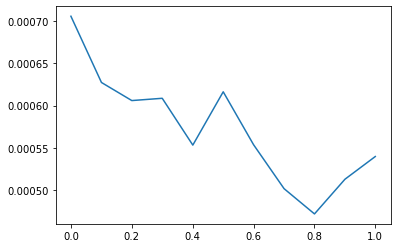

In [22]:
%matplotlib inline

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

hst = athena_read.hst(data_folder+'/OrszagTang.hst')

# cannot use this reliably because hst and hdf can have different number of time steps. In this case,we have the same number of steps
num_timesteps = len(hst['time'])

print(hst.keys())

plt.plot(hst['time'], hst['dt'])


## Reading HDF5 data files 

The hdf5 data files contain all variables inside all meshblocks. There are some merging and calculating work to be done before we can visualizing the result. Fortunately ,Athena++ vis/hdf package takes care of the hard part. 


In [23]:
# Let's example the content of the hdf files

f = h5py.File(data_folder+'/OrszagTang.out2.00001.athdf', 'r')
# variable lists <KeysViewHDF5 ['B', 'Levels', 'LogicalLocations', 'prim', 'x1f', 'x1v', 'x2f', 'x2v', 'x3f', 'x3v']>
print(f.keys())

#<HDF5 dataset "B": shape (3, 512, 64, 64, 64), type "<f4"> 
print(f['prim'])

<KeysViewHDF5 ['B', 'Levels', 'LogicalLocations', 'prim', 'x1f', 'x1v', 'x2f', 'x2v', 'x3f', 'x3v']>
<HDF5 dataset "prim": shape (5, 16, 1, 64, 64), type "<f4">


### Simulation result data 

Raw athdf data has the following keys
<KeysViewHDF5 ['B', 'Levels', 'LogicalLocations', 'prim', 'x1f', 'x1v', 'x2f', 'x2v', 'x3f', 'x3v']>

After athena_read.athdf() call, the result contains keys, which can be used as the field name
['Coordinates', 'DatasetNames', 'MaxLevel', 'MeshBlockSize', 'NumCycles', 'NumMeshBlocks', 'NumVariables', 'RootGridSize', 'RootGridX1', 'RootGridX2', 'RootGridX3', 'Time', 'VariableNames', 'x1f', 'x1v', 'x2f', 'x2v', 'x3f', 'x3v', 'rho', 'press', 'vel1', 'vel2', 'vel3', 'Bcc1', 'Bcc2', 'Bcc3']


In [24]:
def process_athdf(filename, num_step):
    print("Processing ", filename)
    athdf = athena_read.athdf(filename)
    return athdf

# extract list of fields and take a slice in one dimension, dimension can be 'x', 'y', 'z'
def read_all_timestep (data_file_name_template, num_steps, field_names, slice_number, dimension):

    if not dimension in ['x', 'y', 'z']:
        print("dimension can only be 'x/y/z'")
        return
    
    # would ideally process all time steps together and store themn in memory. However, they are too big, will have to trade time for memory 
    result = {}
    for f in field_names:
        result[f] = list()
        
    for i in range(num_steps):
        fn = data_file_name_template.format(str(i).zfill(5))
        athdf = process_athdf(fn, i)
        for f in field_names:
            if dimension == 'x':
                result[f].append(athdf[f][slice_number,:,:])
            elif dimension == 'y':
                result[f].append(athdf[f][:, slice_number,:])
            else:
                result[f].append(athdf[f][:,:, slice_number])
                        
    return result

def animate_slice(data):
    plt.figure()
    for i in range(len(data)):
        plt.imshow(data[i])
        plt.title('Frame %d' % i)
        plt.show()
        plt.pause(0.2)
        clear_output(wait=True)




In [25]:

data_file_name_template = data_folder+'/OrszagTang.out2.{}.athdf'

# this is time consuming, try do it once
data = read_all_timestep(data_file_name_template, num_timesteps, ['press', 'rho'], 0, 'x')



Processing  orz-512x512-c5n.2xlarge/output/OrszagTang.out2.00000.athdf
Processing  orz-512x512-c5n.2xlarge/output/OrszagTang.out2.00001.athdf
Processing  orz-512x512-c5n.2xlarge/output/OrszagTang.out2.00002.athdf
Processing  orz-512x512-c5n.2xlarge/output/OrszagTang.out2.00003.athdf
Processing  orz-512x512-c5n.2xlarge/output/OrszagTang.out2.00004.athdf
Processing  orz-512x512-c5n.2xlarge/output/OrszagTang.out2.00005.athdf
Processing  orz-512x512-c5n.2xlarge/output/OrszagTang.out2.00006.athdf
Processing  orz-512x512-c5n.2xlarge/output/OrszagTang.out2.00007.athdf
Processing  orz-512x512-c5n.2xlarge/output/OrszagTang.out2.00008.athdf
Processing  orz-512x512-c5n.2xlarge/output/OrszagTang.out2.00009.athdf
Processing  orz-512x512-c5n.2xlarge/output/OrszagTang.out2.00010.athdf


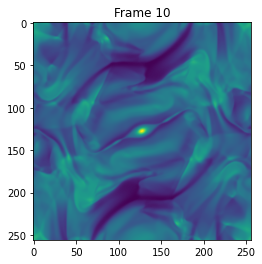

In [26]:
# Cycle through the time steps and look at pressure
animate_slice(data['press'])

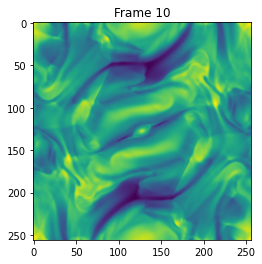

In [27]:
# Now look at density
animate_slice(data['rho'])

# Don't forget to clean up

1. Delete the ParallelCluster
2. Delete the RDS
3. S3 bucket
4. Secrets used in this excercise

Deleting VPC is risky, I will leave it out for you to manually clean it up if you created a new VPC. 

In [28]:
# this is used during developemnt, to reload the module after a change in the module
try:
    del sys.modules['pcluster_athena']
except:
    #ignore if the module is not loaded
    print('Module not loaded, ignore')
from pcluster_athena import PClusterHelper

importlib.reload(workshop)

#from pcluster_athena import PClusterHelper
# create the cluster - # You can rerun the rest of the notebook again with no harm. There are checks in place for existing resoources. 
pcluster_helper = PClusterHelper(pcluster_name, config_name, post_install_script_prefix)

!pcluster delete-cluster --cluster-name $pcluster_helper.pcluster_name --region $REGION

keep_key = False
pcluster_helper.cleanup_after(KeepRDS=True,KeepSSHKey=keep_key)

if not keep_key:
    !rm pcluster-athena-key.pem
    !rm -rf ~/.ssh/pcluster-athena-key.pem

{
  "cluster": {
    "clusterName": "myPC5c",
    "cloudformationStackStatus": "DELETE_IN_PROGRESS",
    "cloudformationStackArn": "arn:aws:cloudformation:us-east-1:192915075361:stack/myPC5c/b7541540-2892-11ec-baa0-0a73f83d45f9",
    "region": "us-east-1",
    "version": "3.0.0",
    "clusterStatus": "DELETE_IN_PROGRESS"
  }
}
Deleting secret slurm_token_myPC5c
Deleting secret munge_key_
Deleting bucket mypc5c-192915075361
Deleting ssh_key pcluster-athena-key
rm: cannot remove ‘pcluster-athena-key.pem’: No such file or directory
